In [16]:
# Autoencoder (non supervisé) sur THCA / PTC
# Question : peut-on discriminer des sous-types moléculaires
#            sans label a priori à partir de l'expression ?

In [17]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

import umap 

import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers, callbacks, Model

In [18]:
# Paramètres de directions
INPUT_CSV = "../data/THCA_expression_matrix_final.csv"
OUTDIR = "../results_autoencoder"
os.makedirs(OUTDIR, exist_ok=True)

RANDOM_SEED = 555
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [19]:
# Paramètres Autoencoder
LATENT_DIM = 16
EPOCHS = 200
BATCH_SIZE = 32
LR = 1e-3

# Clustering
K_MIN, K_MAX = 2, 8  # on teste plusieurs k

# Sélection de gènes (optionnel mais recommandé si très haute dimension)
TOP_VAR_GENES = 500  # mets None pour désactiver

# 1) Charger les données


In [20]:
df = pd.read_csv(INPUT_CSV)
print("CSV chargé :", df.shape)
print("Colonnes (extrait):", df.columns[:10].tolist(), "...")

df.head()

CSV chargé : (60660, 476)
Colonnes (extrait): ['Unnamed: 0', 'ID=TCGA-DJ-A2Q6_AGE=38ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC', 'ID=TCGA-FK-A3SE_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC', 'ID=TCGA-DJ-A2QA_AGE=56ANS_SEX=female_STAGE=Stade_III_MUT=BRAF_TYPE=PTC', 'ID=TCGA-FY-A2QD_AGE=61ANS_SEX=female_STAGE=Stage_NA_MUT=NO_CANONICAL_DRIVER_TYPE=PTC', 'ID=TCGA-EL-A3GR_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC', 'ID=TCGA-EL-A3T7_AGE=47ANS_SEX=female_STAGE=Stade_II_MUT=BRAF_TYPE=PTC', 'ID=TCGA-FE-A230_AGE=30ANS_SEX=female_STAGE=Stage_NA_MUT=BRAF_TYPE=PTC', 'ID=TCGA-EM-A3FO_AGE=40ANS_SEX=male_STAGE=Stade_I_MUT=BRAF_TYPE=PTC', 'ID=TCGA-DJ-A3VB_AGE=52ANS_SEX=male_STAGE=Stade_III_MUT=BRAF_TYPE=PTC'] ...


,Unnamed: 0,ID=TCGA-DJ-A2Q6_AGE=38ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-FK-A3SE_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-DJ-A2QA_AGE=56ANS_SEX=female_STAGE=Stade_III_MUT=BRAF_TYPE=PTC,ID=TCGA-FY-A2QD_AGE=61ANS_SEX=female_STAGE=Stage_NA_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-EL-A3GR_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-EL-A3T7_AGE=47ANS_SEX=female_STAGE=Stade_II_MUT=BRAF_TYPE=PTC,ID=TCGA-FE-A230_AGE=30ANS_SEX=female_STAGE=Stage_NA_MUT=BRAF_TYPE=PTC,ID=TCGA-EM-A3FO_AGE=40ANS_SEX=male_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-DJ-A3VB_AGE=52ANS_SEX=male_STAGE=Stade_III_MUT=BRAF_TYPE=PTC,...,ID=TCGA-DJ-A13S_AGE=19ANS_SEX=female_STAGE=Stade_I_MUT=RAS_TYPE=PTC,ID=TCGA-EM-A3SY_AGE=36ANS_SEX=male_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-EM-A2P1_AGE=33ANS_SEX=male_STAGE=Stage_NA_MUT=BRAF_TYPE=PTC,ID=TCGA-EL-A3T1_AGE=38ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-DJ-A2PS_AGE=40ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-EL-A3TB_AGE=47ANS_SEX=female_STAGE=Stade_III_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-BJ-A45C_AGE=78ANS_SEX=male_STAGE=Stade_III_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-DJ-A3UX_AGE=46ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-DJ-A2PX_AGE=54ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-EL-A3ZS_AGE=22ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC
0,ENSG00000000003.15,6156,7191,2219,5185,4466,9702,2449,6336,5997,...,2448,3693,2691,4533,4471,4742,3753,4488,6131,4097
1,ENSG00000000005.6,7,3,1,0,3,0,0,0,2,...,0,0,0,0,0,3,4,5,6,4
2,ENSG00000000419.13,2540,3815,735,2594,1496,2506,811,1892,3074,...,1851,2286,2227,2406,1832,2172,1491,2061,2439,2218
3,ENSG00000000457.14,1452,767,305,970,820,1036,619,725,856,...,764,459,759,1120,922,1171,962,1151,1213,829
4,ENSG00000000460.17,297,276,28,135,208,315,194,149,317,...,176,185,279,381,226,245,166,250,242,313


In [21]:
#la première colonne est l'ID des gènes donc on veut changer le nom de cette colonne
df.rename(columns={df.columns[0]: 'gene_id'}, inplace=True)
df.set_index('gene_id', inplace=True)
df.head()


,ID=TCGA-DJ-A2Q6_AGE=38ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-FK-A3SE_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-DJ-A2QA_AGE=56ANS_SEX=female_STAGE=Stade_III_MUT=BRAF_TYPE=PTC,ID=TCGA-FY-A2QD_AGE=61ANS_SEX=female_STAGE=Stage_NA_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-EL-A3GR_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-EL-A3T7_AGE=47ANS_SEX=female_STAGE=Stade_II_MUT=BRAF_TYPE=PTC,ID=TCGA-FE-A230_AGE=30ANS_SEX=female_STAGE=Stage_NA_MUT=BRAF_TYPE=PTC,ID=TCGA-EM-A3FO_AGE=40ANS_SEX=male_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-DJ-A3VB_AGE=52ANS_SEX=male_STAGE=Stade_III_MUT=BRAF_TYPE=PTC,ID=TCGA-BJ-A28X_AGE=32ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,...,ID=TCGA-DJ-A13S_AGE=19ANS_SEX=female_STAGE=Stade_I_MUT=RAS_TYPE=PTC,ID=TCGA-EM-A3SY_AGE=36ANS_SEX=male_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-EM-A2P1_AGE=33ANS_SEX=male_STAGE=Stage_NA_MUT=BRAF_TYPE=PTC,ID=TCGA-EL-A3T1_AGE=38ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-DJ-A2PS_AGE=40ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-EL-A3TB_AGE=47ANS_SEX=female_STAGE=Stade_III_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-BJ-A45C_AGE=78ANS_SEX=male_STAGE=Stade_III_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-DJ-A3UX_AGE=46ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-DJ-A2PX_AGE=54ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-EL-A3ZS_AGE=22ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.15,6156,7191,2219,5185,4466,9702,2449,6336,5997,3534,...,2448,3693,2691,4533,4471,4742,3753,4488,6131,4097
ENSG00000000005.6,7,3,1,0,3,0,0,0,2,1,...,0,0,0,0,0,3,4,5,6,4
ENSG00000000419.13,2540,3815,735,2594,1496,2506,811,1892,3074,1769,...,1851,2286,2227,2406,1832,2172,1491,2061,2439,2218
ENSG00000000457.14,1452,767,305,970,820,1036,619,725,856,948,...,764,459,759,1120,922,1171,962,1151,1213,829
ENSG00000000460.17,297,276,28,135,208,315,194,149,317,332,...,176,185,279,381,226,245,166,250,242,313


# 2) Séparer features d'expression vs métadonnées
   Stratégie robuste :
   - on garde UNIQUEMENT les colonnes numériques
   - puis on retire les colonnes obviously "meta" si on les détecte


# 3) Nettoyage minimal

In [22]:
# Sélection des colonnes numériques uniquement (expression des gènes)
df_num = df.select_dtypes(include=[np.number])
print(f"✓ Colonnes numériques extraites: {df_num.shape}")
print(f"  (gènes en lignes, patients en colonnes)")

# Sélection des gènes les plus variables
if TOP_VAR_GENES is not None:
    # IMPORTANT: axis=1 car gènes = lignes, on calcule la variance par ligne
    variances = df_num.var(axis=1).sort_values(ascending=False)
    top_genes = variances.index[:TOP_VAR_GENES]
    df_num = df_num.loc[top_genes]  # .loc car on filtre les lignes
    print(f"✓ Sélection des {TOP_VAR_GENES} gènes les plus variables")
    print(f"  Nouvelle dimension: {df_num.shape}")
else:
    print(f"✓ Tous les gènes conservés: {df_num.shape}")

# Assigner à X pour la suite du pipeline
X = df_num.T  # Transpose: lignes = patients, colonnes = gènes
print(f"✓ Matrice finale X: {X.shape} (patients × gènes)")

X.head()

✓ Colonnes numériques extraites: (60660, 475)
  (gènes en lignes, patients en colonnes)
✓ Sélection des 500 gènes les plus variables
  Nouvelle dimension: (500, 475)
✓ Matrice finale X: (475, 500) (patients × gènes)


gene_id,ENSG00000042832.12,ENSG00000115414.21,ENSG00000198804.2,ENSG00000198886.2,ENSG00000210082.2,ENSG00000198938.2,ENSG00000211592.8,ENSG00000211896.7,ENSG00000164733.22,ENSG00000120885.22,...,ENSG00000100097.12,ENSG00000118705.17,ENSG00000127948.16,ENSG00000074410.14,ENSG00000136352.19,ENSG00000042493.16,ENSG00000091136.15,ENSG00000143761.16,ENSG00000229807.12,ENSG00000172757.13
ID=TCGA-DJ-A2Q6_AGE=38ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,2131062,1722652,891163,524661,494913,364170,88333,70179,1036001,1235363,...,23057,34124,11707,3519,22521,30672,48826,37887,16843,32656
ID=TCGA-FK-A3SE_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,2150009,622736,291615,150668,134770,131377,10476,14425,871157,935110,...,13627,47577,18499,409,16467,37862,17858,42388,6409,35270
ID=TCGA-DJ-A2QA_AGE=56ANS_SEX=female_STAGE=Stade_III_MUT=BRAF_TYPE=PTC,2485163,90318,189345,166924,195922,168881,6872,5079,441622,874656,...,16826,18230,10713,701,8757,24705,6178,24426,12,40839
ID=TCGA-FY-A2QD_AGE=61ANS_SEX=female_STAGE=Stage_NA_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,4231112,6043,253610,170294,134838,128580,4352,14883,161881,146319,...,984,30723,20025,3184,11881,10845,14693,33476,7917,20617
ID=TCGA-EL-A3GR_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,874404,991447,267877,175456,106100,109789,5576,6682,290929,276835,...,9498,17389,8248,1492,9095,13290,18217,20748,13861,17347


# 4) Transformation expression : log1p + scaling


In [23]:
# log1p
X_log = np.log1p(X.values.astype(np.float32))

# Split non supervisé : on garde une val pour early stopping (pas de labels)
X_train, X_val = train_test_split(X_log, test_size=0.2, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_all_sc = scaler.transform(X_log)

print("Preprocess OK. Train:", X_train_sc.shape, "Val:", X_val_sc.shape)

Preprocess OK. Train: (380, 500) Val: (95, 500)


# 5) Construire un autoencoder (dense)

In [24]:
input_dim = X_train_sc.shape[1]
inputs = layers.Input(shape=(input_dim,), name="input")

# Encoder
x = layers.Dense(512, activation="relu",
                 kernel_regularizer=regularizers.l2(1e-4),
                 kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED))(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu",
                 kernel_regularizer=regularizers.l2(1e-4),
                 kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED))(x)
x = layers.Dropout(0.2)(x)
latent = layers.Dense(LATENT_DIM, activation=None, name="latent",
                      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED))(x)

# Decoder
x = layers.Dense(128, activation="relu",
                 kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED))(latent)
x = layers.Dense(512, activation="relu",
                 kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED))(x)
outputs = layers.Dense(input_dim, activation=None, name="recon",
                       kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED))(x)

autoencoder = Model(inputs, outputs, name="autoencoder")
encoder = Model(inputs, latent, name="encoder")

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="mse"
)

autoencoder.summary()

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

hist = autoencoder.fit(
    X_train_sc, X_train_sc,
    validation_data=(X_val_sc, X_val_sc),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       256,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ recon (Dense)                   │ (None, 500)            │       256,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,964 (2.48 MB)

 Trainable params: 648,964 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.0841 - val_loss: 0.8788
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7913 - val_loss: 0.6801
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6526 - val_loss: 0.5584
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5787 - val_loss: 0.5241
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5386 - val_loss: 0.5022
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5040 - val_loss: 0.4836
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4887 - val_loss: 0.4665
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4611 - val_loss: 0.4397
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4430 - val_loss: 0.4365
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4287 - val_loss: 0.4156
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4105 - val_loss: 0.4035
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

In [25]:
# Courbes loss
plt.figure()
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE recon")
plt.title("Autoencoder training curves")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "autoencoder_loss_curves.pdf"), dpi=200)
plt.close()

# 6) Extraire l'espace latent pour TOUS les échantillons

In [26]:
Z = encoder.predict(X_all_sc, batch_size=256, verbose=0)
print("Latent embedding Z:", Z.shape)

# Extract sample IDs from column names
sample_ids = X.index.tolist()  # X was transposed, so index contains sample IDs
id_col = "sample_id"

latent_df = pd.DataFrame(Z, columns=[f"z{i+1}" for i in range(Z.shape[1])])
latent_df.insert(0, id_col, sample_ids)
latent_path = os.path.join(OUTDIR, "latent_embedding.csv")
latent_df.to_csv(latent_path, index=False)
print("Saved:", latent_path)

Latent embedding Z: (475, 16)
Saved: ../results_autoencoder\latent_embedding.csv


# 7) Clustering dans l'espace latent (KMeans + sélection k)

In [27]:
best_k = None
best_sil = -1
sil_scores = []

for k in range(K_MIN, min(K_MAX, len(Z)-1) + 1):
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=20)
    labels = km.fit_predict(Z)
    # silhouette nécessite >1 cluster et pas cluster singleton massifs
    try:
        sil = silhouette_score(Z, labels)
    except Exception:
        sil = np.nan
    sil_scores.append((k, sil))
    if np.isfinite(sil) and sil > best_sil:
        best_sil = sil
        best_k = k

sil_df = pd.DataFrame(sil_scores, columns=["k", "silhouette"])
sil_df.to_csv(os.path.join(OUTDIR, "silhouette_scores.csv"), index=False)

plt.figure()
plt.plot(sil_df["k"], sil_df["silhouette"], marker="o")
plt.xlabel("k (KMeans)")
plt.ylabel("Silhouette score")
plt.title("Choix de k sur l'espace latent")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "k_selection_silhouette.pdf"), dpi=200)
plt.close()

if best_k is None:
    best_k = 3  # fallback
print(f"Best k (silhouette): {best_k}  | best silhouette: {best_sil:.3f}")

kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_SEED, n_init=30)
cluster_labels = kmeans.fit_predict(Z)

clusters_df = pd.DataFrame({id_col: sample_ids, "cluster": cluster_labels})
clusters_path = os.path.join(OUTDIR, "clusters_kmeans.csv")
clusters_df.to_csv(clusters_path, index=False)
print("Saved:", clusters_path)

c:\Users\assou\anaconda3\envs\bioinfo\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\assou\anaconda3\envs\bioinfo\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\assou\anaconda3\envs\bioinfo\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\assou\anaconda3\envs\bioinfo\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarn

Best k (silhouette): 2  | best silhouette: 0.263


c:\Users\assou\anaconda3\envs\bioinfo\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Saved: ../results_autoencoder\clusters_kmeans.csv


# 8) Visualisation 2D : UMAP

c:\Users\assou\anaconda3\envs\bioinfo\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\assou\AppData\Local\Temp\ipykernel_25696\3627315690.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20b', n_clusters)


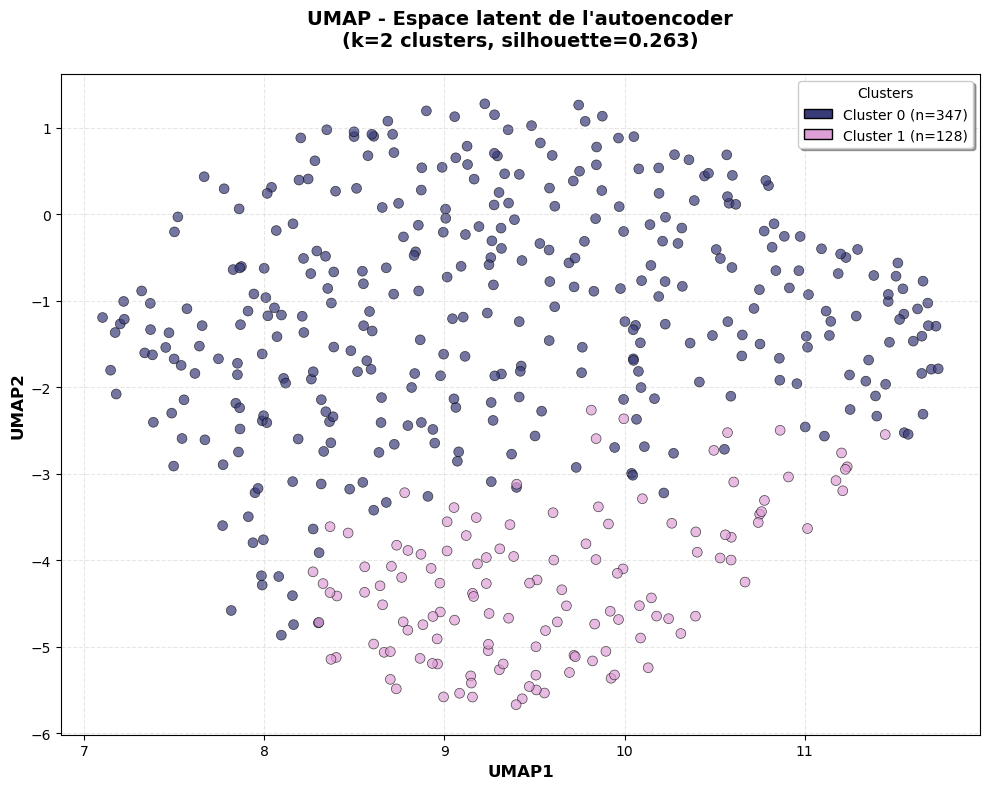

In [28]:
reducer = umap.UMAP(n_neighbors=20, min_dist=0.2, random_state=RANDOM_SEED, n_jobs = -1)
emb2d = reducer.fit_transform(Z)
method = "UMAP"

# Créer une palette de couleurs pour les clusters
from matplotlib import cm
import matplotlib.patches as mpatches

n_clusters = len(np.unique(cluster_labels))
colors = cm.get_cmap('tab20b', n_clusters)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    emb2d[:, 0], 
    emb2d[:, 1], 
    c=cluster_labels, 
    cmap='tab20b',
    s=50, 
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)

# Ajouter la légende des clusters
legend_elements = [
    mpatches.Patch(
        facecolor=colors(i), 
        edgecolor='black',
        label=f'Cluster {i} (n={np.sum(cluster_labels == i)})'
    )
    for i in range(n_clusters)
]
plt.legend(
    handles=legend_elements, 
    title='Clusters',
    loc='best',
    frameon=True,
    fancybox=True,
    shadow=True
)

plt.title(
    f'{method} - Espace latent de l\'autoencoder\n(k={best_k} clusters, silhouette={best_sil:.3f})',
    fontsize=14,
    fontweight='bold',
    pad=20
)
plt.xlabel(f'{method}1', fontsize=12, fontweight='bold')
plt.ylabel(f'{method}2', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"latent_umap_clusters.pdf"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

C:\Users\assou\AppData\Local\Temp\ipykernel_25696\3397914723.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_tsne = cm.get_cmap('tab20b', n_clusters_tsne)


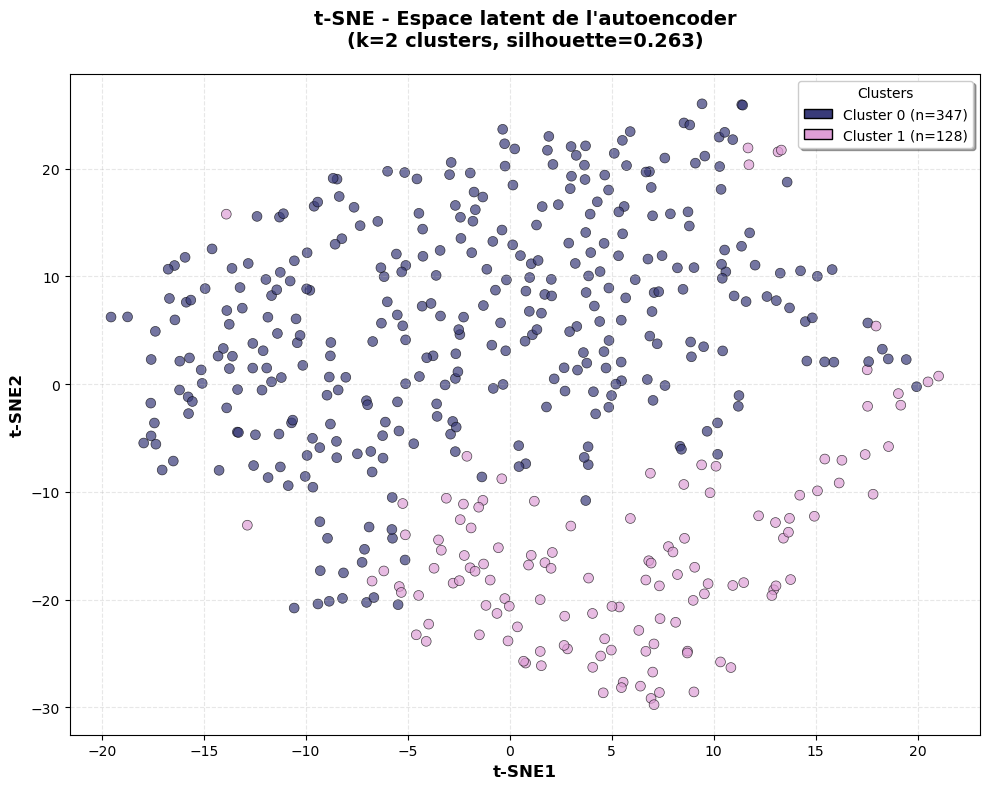

In [29]:
# t-SNE
from sklearn.manifold import TSNE

tsne_reducer = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, max_iter=1000)
emb2d_tsne = tsne_reducer.fit_transform(Z)
method_tsne = "t-SNE"

# Créer une palette de couleurs pour les clusters
n_clusters_tsne = len(np.unique(cluster_labels))
colors_tsne = cm.get_cmap('tab20b', n_clusters_tsne)

plt.figure(figsize=(10, 8))
scatter_tsne = plt.scatter(
    emb2d_tsne[:, 0], 
    emb2d_tsne[:, 1], 
    c=cluster_labels, 
    cmap='tab20b',
    s=50, 
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)

# Ajouter la légende des clusters
legend_elements_tsne = [
    mpatches.Patch(
        facecolor=colors_tsne(i), 
        edgecolor='black',
        label=f'Cluster {i} (n={np.sum(cluster_labels == i)})'
    )
    for i in range(n_clusters_tsne)
]
plt.legend(
    handles=legend_elements_tsne, 
    title='Clusters',
    loc='best',
    frameon=True,
    fancybox=True,
    shadow=True
)

plt.title(
    f'{method_tsne} - Espace latent de l\'autoencoder\n(k={best_k} clusters, silhouette={best_sil:.3f})',
    fontsize=14,
    fontweight='bold',
    pad=20
)
plt.xlabel(f'{method_tsne}1', fontsize=12, fontweight='bold')
plt.ylabel(f'{method_tsne}2', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "latent_tsne_clusters.pdf"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 9) Relier clusters aux métadonnées dispo dans les noms des échantillons

In [30]:
# Les méta sont inclues dans les noms des écantillons sous forme "ID=TCGA-DJ-A2Q6_AGE=38ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC"
# Extraire les métadonnées des noms d'échantillons et les associer aux clusters

import re

# Fonction pour parser les métadonnées depuis le nom
def parse_sample_name(sample_name):
    """Extrait les métadonnées du format ID=..._AGE=...ANS_SEX=..._STAGE=..._MUT=..._TYPE=..."""
    meta_dict = {}
    
    # Extraction par regex
    patterns = {
        'patient_id': r'ID=([^_]+)',
        'age': r'AGE=(\d+)ANS',
        'sex': r'SEX=([^_]+)',
        'stage': r'STAGE=(Stade_[^_]+|Stage_[^_]+)',
        'mutation': r'MUT=([^_]+)',
        'type': r'TYPE=([^_]+)'
    }
    
    for key, pattern in patterns.items():
        match = re.search(pattern, sample_name)
        if match:
            meta_dict[key] = match.group(1)
        else:
            meta_dict[key] = None
    
    return meta_dict

# Extraire les métadonnées pour tous les échantillons
meta_list = [parse_sample_name(sid) for sid in sample_ids]
meta_df = pd.DataFrame(meta_list)

# Ajouter les clusters
meta_df['cluster'] = cluster_labels
meta_df['sample_id'] = sample_ids

print("✓ Métadonnées extraites:")
print(meta_df.head())

# Créer des heatmaps des tableaux croisés dans un seul PDF
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# Créer le PDF
pdf_path = os.path.join(OUTDIR, "tableaux_croises_clusters.pdf")

with PdfPages(pdf_path) as pdf:
    
    # 1. Cluster vs Stage
    ct_stage = pd.crosstab(meta_df["cluster"], meta_df["stage"], dropna=False)
    ct_stage.to_csv(os.path.join(OUTDIR, "cluster_vs_stage.csv"))
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(ct_stage, annot=True, fmt='d', cmap='Blues', 
                linewidths=0.5, linecolor='black', cbar_kws={'label': 'Nombre d\'échantillons'})
    plt.title('Tableau croisé : Cluster × Stade tumoral', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Stade', fontsize=12, fontweight='bold')
    plt.ylabel('Cluster', fontsize=12, fontweight='bold')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
    # 2. Cluster vs Mutation
    ct_mut = pd.crosstab(meta_df["cluster"], meta_df["mutation"], dropna=False)
    ct_mut.to_csv(os.path.join(OUTDIR, "cluster_vs_mutation.csv"))
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(ct_mut, annot=True, fmt='d', cmap='Greens',
                linewidths=0.5, linecolor='black', cbar_kws={'label': 'Nombre d\'échantillons'})
    plt.title('Tableau croisé : Cluster × Mutation', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Mutation', fontsize=12, fontweight='bold')
    plt.ylabel('Cluster', fontsize=12, fontweight='bold')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
    # 3. Cluster vs Sex
    ct_sex = pd.crosstab(meta_df["cluster"], meta_df["sex"], dropna=False)
    ct_sex.to_csv(os.path.join(OUTDIR, "cluster_vs_sex.csv"))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(ct_sex, annot=True, fmt='d', cmap='Purples',
                linewidths=0.5, linecolor='black', cbar_kws={'label': 'Nombre d\'échantillons'})
    plt.title('Tableau croisé : Cluster × Sexe', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Sexe', fontsize=12, fontweight='bold')
    plt.ylabel('Cluster', fontsize=12, fontweight='bold')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
    # 4. Cluster vs Type
    ct_type = pd.crosstab(meta_df["cluster"], meta_df["type"], dropna=False)
    ct_type.to_csv(os.path.join(OUTDIR, "cluster_vs_type.csv"))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(ct_type, annot=True, fmt='d', cmap='Oranges',
                linewidths=0.5, linecolor='black', cbar_kws={'label': 'Nombre d\'échantillons'})
    plt.title('Tableau croisé : Cluster × Type de cancer', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Type', fontsize=12, fontweight='bold')
    plt.ylabel('Cluster', fontsize=12, fontweight='bold')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
    # 5. Âge moyen par cluster (barplot)
    meta_df['age'] = pd.to_numeric(meta_df['age'], errors='coerce')
    age_stats = meta_df.groupby('cluster')['age'].agg(['mean', 'std', 'count'])
    age_stats.to_csv(os.path.join(OUTDIR, "cluster_vs_age_stats.csv"))
    
    plt.figure(figsize=(8, 6))
    ax = age_stats['mean'].plot(kind='bar', yerr=age_stats['std'], capsize=5, 
                                  color='steelblue', edgecolor='black', linewidth=1.5)
    plt.title('Âge moyen par cluster (± écart-type)', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Cluster', fontsize=12, fontweight='bold')
    plt.ylabel('Âge moyen (années)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Ajouter les effectifs sur les barres
    for i, (idx, row) in enumerate(age_stats.iterrows()):
        ax.text(i, row['mean'] + row['std'] + 2, f"n={int(row['count'])}", 
                ha='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    pdf.savefig()
    plt.close()

print(f"\n✅ Tableaux croisés sauvegardés dans : {pdf_path}")
print("\n=== Résumés des tableaux croisés ===")
print("\nCluster vs Stage:")
print(ct_stage)
print("\nCluster vs Mutation:")
print(ct_mut)
print("\nCluster vs Sex:")
print(ct_sex)
print("\nCluster vs Type:")
print(ct_type)
print("\nÂge par cluster:")
print(age_stats)

✓ Métadonnées extraites:
     patient_id age     sex      stage mutation type  cluster  \
0  TCGA-DJ-A2Q6  38  female    Stade_I     BRAF  PTC        0   
1  TCGA-FK-A3SE  31  female    Stade_I       NO  PTC        0   
2  TCGA-DJ-A2QA  56  female  Stade_III     BRAF  PTC        1   
3  TCGA-FY-A2QD  61  female   Stage_NA       NO  PTC        1   
4  TCGA-EL-A3GR  31  female    Stade_I     BRAF  PTC        0   

                                           sample_id  
0  ID=TCGA-DJ-A2Q6_AGE=38ANS_SEX=female_STAGE=Sta...  
1  ID=TCGA-FK-A3SE_AGE=31ANS_SEX=female_STAGE=Sta...  
2  ID=TCGA-DJ-A2QA_AGE=56ANS_SEX=female_STAGE=Sta...  
3  ID=TCGA-FY-A2QD_AGE=61ANS_SEX=female_STAGE=Sta...  
4  ID=TCGA-EL-A3GR_AGE=31ANS_SEX=female_STAGE=Sta...  

✅ Tableaux croisés sauvegardés dans : ../results_autoencoder\tableaux_croises_clusters.pdf

=== Résumés des tableaux croisés ===

Cluster vs Stage:
stage    Stade_I  Stade_II  Stade_III  Stade_IV  Stage_NA
cluster                                        